# 라이브러리

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
import lightgbm
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from lightgbm import plot_importance
import joblib
from itertools import product

import warnings
warnings.filterwarnings("ignore")



--------------------------------------------------------

--------------------------------------------------------

# 함수

### mm

In [2]:
def mm(x):
    if x.mean()!=0:
        z=(x.max()-x.min())/x.mean() 
    else:z=0
    return z


--------------------------------------------------------

### linear

In [3]:
def linear(x,model,k=2,period=48,seq=48):
    value=[]
    
    for  i in range(0,len(x)-k*period,seq):
        res_fit=ols(model,data=x.iloc[range(i,i+k*period+1,period)]).fit()
        value.append([res_fit.pvalues[1],res_fit.params[1]])
    value=pd.DataFrame(value,columns=["p","ceof"])
    day=np.repeat(range(k,int(x.shape[0]/period)+k+1),period/seq)
    value["Day"]=day[:value.shape[0]]
    return value

In [4]:
def linear1(x,p=0.05):
    if x['p']<p:
        if x['ceof']>0: return "positice"
        else: return "negative"
    else: return "regX"


In [5]:
def linear2(x):
    if x['ceof']>0: return "positive"
    else: return "negative"
   

--------------------------------------------------------

### km

In [6]:
def km_clu(x):
    distortions=[]
    for i in range(1,11):
        km=KMeans(n_clusters=i,
                  init="k-means++",
                  n_init=10,
                  max_iter=300,
                  random_state=0)
        km.fit(x)
        distortions.append(km.inertia_)
    plt.plot(range(1,11),distortions,marker="o")


In [7]:
def plt_scat(data,km,y):
    plt.scatter(data[km==y].iloc[:,0],
                data[km==y].iloc[:,1],
                s=20,
                marker="o",
                label=str(y)
               )


In [8]:
def scatt(data,km,n=2,auto=True):
    
    if auto==True:n=len(np.unique(km))
    for i in range(n):
        plt_scat(data,km,i)
    plt.legend(scatterpoints=1)
    plt.grid()
    plt.tight_layout()
    plt.show()

--------------------------------------------------------

### lihgtgbm

In [9]:
from lightgbm import LGBMRegressor

# Get the model and the predictiocns in (a) - (b)

def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test,params):
    
    # (a) Modeling  
    model = LGBMRegressor(**params,alpha=q)
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=1000, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

In [10]:
# Target 예측

def train_data(X_train, Y_train, X_valid, Y_valid, X_test,params):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test,params)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

--------------------------------------------------------

### pinball

In [11]:
def pinball(y_true, y_pred,tao):
    
    pin = np.mean(np.maximum(y_true - y_pred, 0).iloc[:,int(tao*10-1)] * tao +
                 np.maximum(y_pred - y_true, 0).iloc[:,int(tao*10-1)] * (1 - tao))
    return pin

In [15]:
def p_error(path,k,model_n,y_data,day,log=False):
    quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    error_1=pd.DataFrame()
    if log==True:
        y_data=np.exp(y_data)-1
    if k>1:
        for i in range(k):
            for j in range(model_n):
                pred=pd.read_csv("%sresult%s_%s_fold%s.csv"%(path,day,j,i))
                
                if log==True:
                    pred=np.exp(pred)-1
                    
                error=0
                for q in quantiles:
                    pin=pinball(y_data,pred,q)
                    error=error+pin
                error_1.loc["%s"%i,"model_%s"%j]=error/len(quantiles)
    else:
        for j in range(model_n):
            pred=pd.read_csv("%sresult%s_%s.csv"%(path,day,j))
            
            if log==True:
                pred=np.exp(pred)-1
       
            error=0
            for q in quantiles:
                pin=pinball(y_data,pred,q)
                error=error+pin
            error_1.loc["0","model_%s"%j]=error/len(quantiles)
           
    return error_1

--------------------------------------------------------

### submission 예측 불러오기

In [99]:
def subb(path,k=1,model_n=1,day=7,log=False):
    pred0=np.array(0)
    if k>1:
        for i in range(k):
            
            for j in range(model_n):
                pred=pd.read_csv("%sresult%s_%s_fold%s.csv"%(path,day,j,i))
                
                if log==True:
                    pred=np.round(np.exp(pred)-1,1)
                    
                pred0=pred0+pred
    
    else:
        for j in range(model_n):
            pred=pd.read_csv("%sresult%s_%s.csv"%(path,day,j))
            if log==True:
                pred=np.round(np.exp(pred)-1,1)
            pred0=pred0+pred

    return pred0/(k*model_n)
                    

--------------------------------------------------------

--------------------------------------------------------

# 데이터 불러오기 및 전처리

In [18]:
train = pd.read_csv('./train.csv')

--------------------------------------------------------

### SUN 

In [19]:
train['SUN']=train['DNI']+train['DHI']

--------------------------------------------------------

### day: rollmean mean std 
### Hour,Minute: rollmean rollstd 

In [20]:
col_name=pd.Series(train.columns.tolist())

d_std_name="d_"+col_name[3:]+"_std"
d_mean_name="d_"+col_name[3:]+"_mean"
d_rollmean_name="d_"+col_name[3:]+"_rollmean"


h_rollstd_name="h_"+col_name[3:]+"_rollstd"
h_rollmean_name="h_"+col_name[3:]+"_rollmean"

train[d_mean_name]=train.groupby('Day')[col_name[3:]].transform(lambda x: x.mean())
train[d_std_name]=train.groupby('Day')[col_name[3:]].transform(lambda x: x.std())
train[d_rollmean_name]=train.groupby('Day')[col_name[3:]].transform(lambda x: x.rolling(3).mean())

train[h_rollstd_name]=train.groupby(['Hour',"Minute"])[col_name[3:]].transform(lambda x: x.rolling(3).std())
train[h_rollmean_name]=train.groupby(['Hour',"Minute"])[col_name[3:]].transform(lambda x: x.rolling(3).mean())
                                     

--------------------------------------------------------

### day: mm
### Hour,Minute: mm

In [21]:
train["d_SUN_mm"]=train.groupby('Day')['SUN'].transform(mm)
train["h_SUN_mm"]=train.groupby(["Hour","Minute"])['SUN'].transform(mm)

--------------------------------------------------------

### reg

In [22]:
reg=linear(train,"d_TARGET_mean~Day",k=5,seq=48)

In [23]:
reg[reg["p"]<=0.05]

,p,ceof,Day
24,0.041148,-1.489038,29
25,0.007187,-2.145069,30
26,0.035489,-1.763226,31
34,0.003587,2.833506,39
41,0.031267,-2.299923,46
...,...,...,...
990,0.046313,-3.651896,995
991,0.009882,-4.951395,996
992,0.009587,-4.967010,997
1032,0.019749,2.264966,1037


In [24]:
reg["linear"]=reg.apply(linear2,axis=1)

In [25]:
train=pd.merge(train,reg.loc[:,["Day","linear"]],on="Day",how="left")

In [26]:
train["linear"]=train["linear"].astype("category")

--------------------------------------------------------

### RH_WS_km

In [27]:
RH_WS=train[["Day","d_RH_mean","d_WS_mean"]].drop_duplicates(["Day"],keep="first")
scaler = MinMaxScaler()
scaler.fit(RH_WS.iloc[:,1:3])
RH_WS2= scaler.transform(RH_WS.iloc[:,1:3])
RH_WS2=pd.DataFrame(RH_WS2)


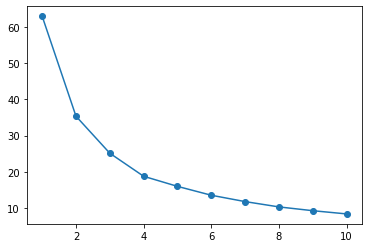

In [28]:
km_clu(RH_WS2)

In [29]:
kmm=KMeans(n_clusters=3,
             init="k-means++",
             n_init=10,
             max_iter=300,
             random_state=0)
RH_WS_km=kmm.fit_predict(RH_WS2)

In [30]:
RH_WS["RH_WS_km"]=RH_WS_km

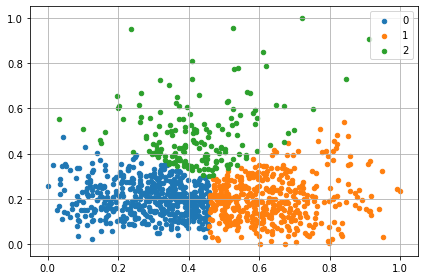

In [31]:
scatt(RH_WS2,RH_WS_km)

In [32]:
train=pd.merge(train,RH_WS.loc[:,["Day","RH_WS_km"]],on="Day",how="left")
train["RH_WS_km"]=train["RH_WS_km"].astype("category")

--------------------------------------------------------

### minmax_scaler

In [33]:
scaler2 = MinMaxScaler()
scaler2.fit(train[train.columns.difference(["Day","Hour","Minute","linear","RH_WS_km","TARGET"])])
train_scaler=scaler2.transform(train[train.columns.difference(["Day","Hour","Minute","linear","RH_WS_km","TARGET"])])
train[train.columns.difference(["Day","Hour","Minute","linear","RH_WS_km","TARGET"])]=train_scaler


--------------------------------------------------------

### TARGET log

In [34]:
train["TARGET"]=np.log(train["TARGET"]+1)

--------------------------------------------------------

### 7일 8일 데이터 생성 

In [35]:
train['Target1'] = train['TARGET'].shift(-48)
train['Target2'] = train['TARGET'].shift(-48*2)     

In [36]:
#train=train[(train.Hour>4)&(train.Hour<21)]
#train=train.drop(["TARGET","DHI","DNI","WS","RH","T","SUN","Minute","Hour","Day"],axis=1)

--------------------------------------------------------

### NA제거

In [37]:
train=train.dropna(axis=0)

--------------------------------------------------------

# 변수선택

#변수 선택 코드

## 선택하는 법

In [33]:
#Target_list=["Target1","Target2"]
#train_name=train.iloc[:,:9].columns.tolist()

In [34]:
#select_list=["SUN","d_DHI_mean"]

In [38]:
#train.loc[:,train_name+select_list+Target_list]

--------------------------------------------------------

--------------------------------------------------------

### 변수 선택 시도

In [39]:
Target_list=["Target1","Target2"]
train_name=train.iloc[:,:9].columns.tolist()

In [40]:
#변수 이름 보기
#train.columns.tolist()

In [41]:
select_list=["d_DHI_mean","linear","RH_WS_km","d_TARGET_rollmean",
             "h_TARGET_rollmean","d_SUN_mm","h_SUN_mm","d_TARGET_std"]


In [42]:
train=train.loc[:,train_name+select_list+Target_list]

In [45]:
train=train.drop(["Day","Minute"],axis=1)

--------------------------------------------------------

## 버리는 법

In [43]:
#drop_list = ["h_RH_rollmean","Day"]

In [44]:
#train = train.drop(drop_list,axis=1)

--------------------------------------------------------

# 모델링(파라미터찾기용)  

## data분할 및 parmeter 수정  

--------------------------------------------------------

### data분할

In [46]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(train.iloc[:, :-2], train.iloc[:, -2], test_size=0.25, random_state=0)
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(train.iloc[:, :-2], train.iloc[:, -1], test_size=0.25, random_state=0)

In [47]:
train

,Hour,DHI,DNI,WS,RH,T,TARGET,d_DHI_mean,linear,RH_WS_km,d_TARGET_rollmean,h_TARGET_rollmean,d_SUN_mm,h_SUN_mm,d_TARGET_std,Target1,Target2
242,1,0.0,0.0,0.158333,0.748620,0.370370,0.0,0.146804,negative,1,0.0,0.0,0.204268,0.0,0.312564,0.0,0.0
243,1,0.0,0.0,0.166667,0.748620,0.370370,0.0,0.146804,negative,1,0.0,0.0,0.204268,0.0,0.312564,0.0,0.0
244,2,0.0,0.0,0.183333,0.744508,0.370370,0.0,0.146804,negative,1,0.0,0.0,0.204268,0.0,0.312564,0.0,0.0
245,2,0.0,0.0,0.183333,0.744292,0.351852,0.0,0.146804,negative,1,0.0,0.0,0.204268,0.0,0.312564,0.0,0.0
246,3,0.0,0.0,0.191667,0.742560,0.351852,0.0,0.146804,negative,1,0.0,0.0,0.204268,0.0,0.312564,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52459,21,0.0,0.0,0.291667,0.523536,0.333333,0.0,0.135636,negative,2,0.0,0.0,0.225764,0.0,0.299886,0.0,0.0
52460,22,0.0,0.0,0.325000,0.504707,0.314815,0.0,0.135636,negative,2,0.0,0.0,0.225764,0.0,0.299886,0.0,0.0
52461,22,0.0,0.0,0.341667,0.504491,0.314815,0.0,0.135636,negative,2,0.0,0.0,0.225764,0.0,0.299886,0.0,0.0
52462,23,0.0,0.0,0.358333,0.528839,0.314815,0.0,0.135636,negative,2,0.0,0.0,0.225764,0.0,0.299886,0.0,0.0


In [48]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#test y만들기

In [49]:
y7_test=pd.DataFrame()
for i in quantiles:
    y7_test["%s"%i]=Y_test_1
y7_test=np.array(y7_test)
y7_test

array([[4.0882957 , 4.0882957 , 4.0882957 , ..., 4.0882957 , 4.0882957 ,
        4.0882957 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.29246852, 4.29246852, 4.29246852, ..., 4.29246852, 4.29246852,
        4.29246852],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.4357472 , 4.4357472 , 4.4357472 , ..., 4.4357472 , 4.4357472 ,
        4.4357472 ]])

In [50]:
y8_test=pd.DataFrame()
for i in quantiles:
    y8_test["%s"%i]=Y_test_2
y8_test=np.array(y8_test)
y8_test

array([[3.21218023, 3.21218023, 3.21218023, ..., 3.21218023, 3.21218023,
        3.21218023],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [4.33020336, 4.33020336, 4.33020336, ..., 4.33020336, 4.33020336,
        4.33020336],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.16260437, 2.16260437, 2.16260437, ..., 2.16260437, 2.16260437,
        2.16260437]])

--------------------------------------------------------

### parameter 수정

In [51]:
#n_est=[3000]
#num_leav=[31]
#par=[n_est,num_leav]
#par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])
#k_n=3


In [52]:
#quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

--------------------------------------------------------

## Kfold

### 7일

#### parameter 수정

In [53]:
n_est=[1500]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])
k_n=2


In [54]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 예측모형

In [55]:
kfold_path7="./model/"

In [56]:
from sklearn.model_selection import KFold
folds = KFold(n_splits = k_n, shuffle = True, random_state = 2021)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
            "feature_fraction_bynode":0.8,"bagging_freq":10,
            "num_leaves":par.loc[i,"num_leav"]}                   
                              
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train_1)) :
        X_train_7, Y_train_7 = X_train_1.iloc[trn_idx], Y_train_1.iloc[trn_idx] 
        X_valid_7, Y_valid_7 = X_train_1.iloc[val_idx], Y_train_1.iloc[val_idx]
        
        K_models_7, K_results_7 = train_data(X_train_7, Y_train_7, 
                                         X_valid_7, Y_valid_7,
                                         X_test_1,param)
    
        joblib.dump(K_models_7, kfold_path7+'model7_%s_fold%s.pkl'%(i,n_fold))
        K_results_7.to_csv(kfold_path7+"result7_%s_fold%s.csv"%(i,n_fold),index=False)


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0726541
[1000]	valid_0's quantile: 0.0705875
[1500]	valid_0's quantile: 0.0695871
Did not meet early stopping. Best iteration is:
[1500]	valid_0's quantile: 0.0695871
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores

#### 오차

In [57]:
model_error7=p_error(kfold_path7,k=k_n,model_n=len(par),y_data=y7_test,day=7,log=True)
model_error7

,model_0
0,1.789797
1,1.825601


In [58]:
par

,n_est,num_leav
0,1500,31


--------------------------------------------------------

### 8일

#### parameter 수정

In [59]:
n_est=[1500,3000]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])
k_n=2


In [60]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 8일 예측모형

In [61]:
kfold_path8="./model/"

In [62]:
from sklearn.model_selection import KFold
folds = KFold(n_splits = k_n, shuffle = True, random_state = 2021)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
            "feature_fraction_bynode":0.8,"bagging_freq":10,
            "num_leaves":par.loc[i,"num_leav"]}                   
                              
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train_2)) :
        X_train_8, Y_train_8 = X_train_2.iloc[trn_idx], Y_train_2.iloc[trn_idx] 
        X_valid_8, Y_valid_8 = X_train_2.iloc[val_idx], Y_train_2.iloc[val_idx]

        K_models_8, K_results_8 = train_data(X_train_8, Y_train_8, 
                                         X_valid_8, Y_valid_8,
                                         X_test_2,param)
    
        joblib.dump(K_models_8, kfold_path8+'model8_%s_fold%s.pkl'%(i,n_fold))
        K_results_8.to_csv(kfold_path8+"result8_%s_fold%s.csv"%(i,n_fold),index=False)


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0694349
[1000]	valid_0's quantile: 0.0684098
[1500]	valid_0's quantile: 0.0675732
Did not meet early stopping. Best iteration is:
[1493]	valid_0's quantile: 0.0675727
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores

#### 오차

In [63]:
model_error8=p_error(kfold_path8,k=k_n,model_n=len(par),y_data=y8_test,day=8,log=True)
model_error8

,model_0,model_1
0,1.928632,1.885417
1,1.928027,1.888876


--------------------------------------------------------

## 그냥 모델링

--------------------------------------------------------

### 7일

#### parameter 수정

In [64]:
n_est=[1500]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])


In [65]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 7일 예측모형

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [66]:
path7="./model2/"

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [67]:
from sklearn.model_selection import train_test_split
X_train_7, X_valid_7, Y_train_7, Y_valid_7 = train_test_split(X_train_1, 
                                                              Y_train_1, 
                                                              test_size=0.3, 
                                                              random_state=0)

for i in range(len(par)):
    
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
            "feature_fraction_bynode":0.8,"bagging_freq":10,
            "num_leaves":par.loc[i,"num_leav"]}                   
    models_7, results_7 = train_data(X_train_7, Y_train_7,
                                     X_valid_7, Y_valid_7,
                                     X_test_1,param)
    
    joblib.dump(models_7, path7+'model7_%s.pkl'%i)
    results_7.to_csv(path7+"result7_%s.csv"%i,index=False)
    


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.069614
[1000]	valid_0's quantile: 0.069457
[1500]	valid_0's quantile: 0.0677153
Did not meet early stopping. Best iteration is:
[1499]	valid_0's quantile: 0.067715
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores do

--------------------------------------------------------

#### 오차

In [68]:
model_error7=p_error(path7,k=1,model_n=len(par),y_data=y7_test,day=7,log=True)
model_error7

,model_0
0,1.767512


#### importance

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [69]:
model7=joblib.load(path7+"model7_0.pkl")

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

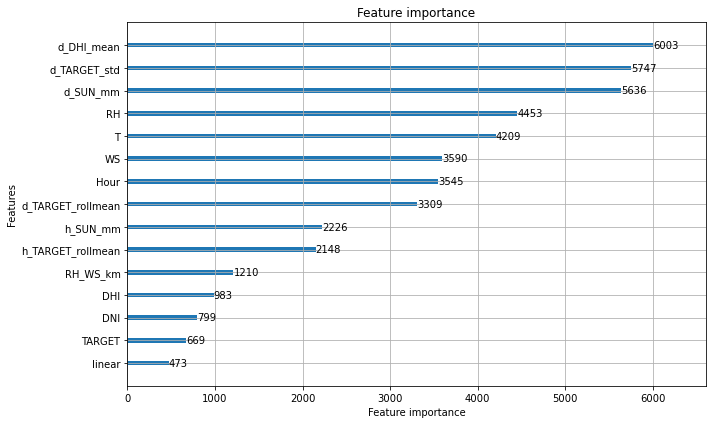

In [70]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(model7[1],ax=ax)
plt.tight_layout()


In [72]:
fe_import=pd.DataFrame(zip(model7[1].feature_importances_,X_train_1.columns.tolist()),columns=["value","feature"])


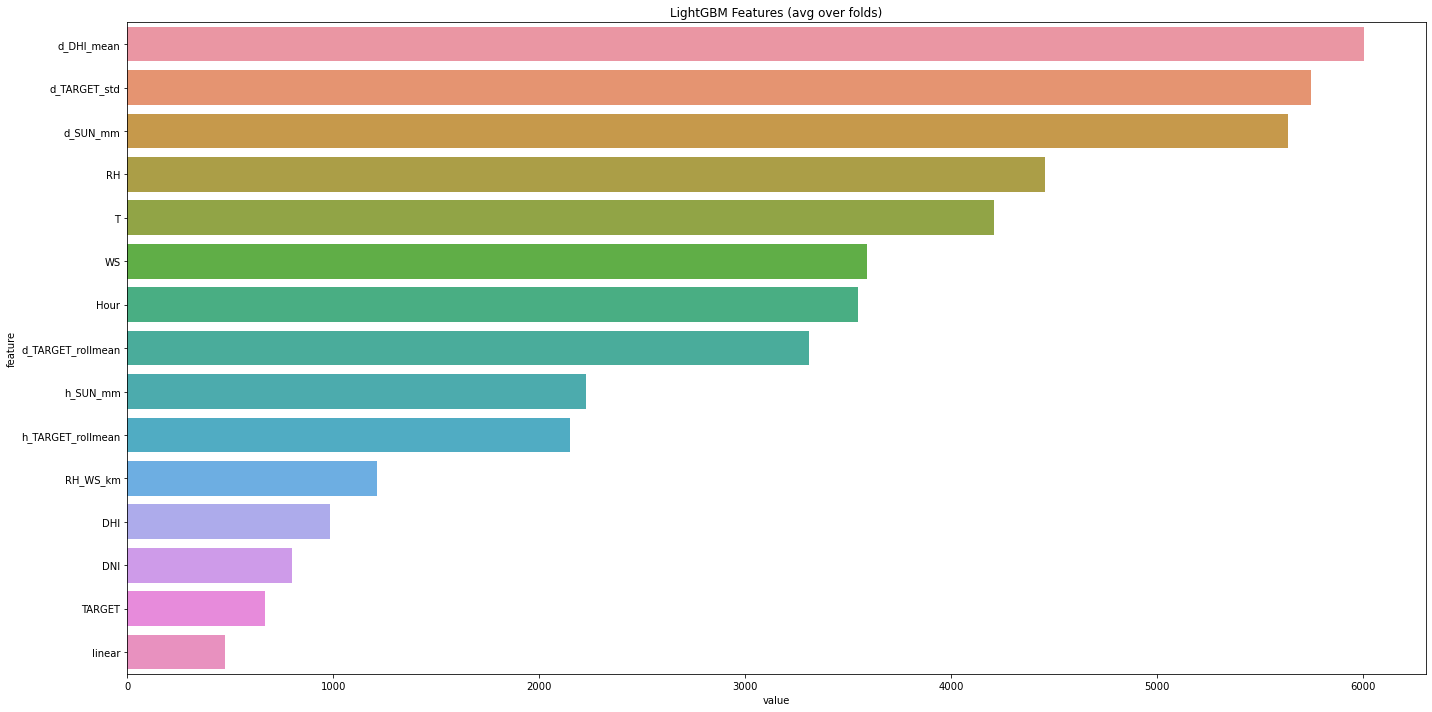

In [73]:
plt.figure(figsize=(20, 10))
sns.barplot(x="value", y="feature", data=fe_import.sort_values(by="value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

--------------------------------------------------------

### 8일

#### parameter 수정

In [74]:
n_est=[1500,3000]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])


In [97]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 8일 예측모형

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [98]:
path8="./model2/"

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [99]:
from sklearn.model_selection import train_test_split
X_train_8, X_valid_8, Y_train_8, Y_valid_8 = train_test_split(X_train_2, 
                                                              Y_train_2, 
                                                              test_size=0.3, 
                                                              random_state=0)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
           # "feature_fraction_bynode":0.8,"bagging_freq":2,
            "num_leaves":par.loc[i,"num_leav"]}                   

        
    models_8, results_8 = train_data(X_train_8, Y_train_8, 
                                         X_valid_8, Y_valid_8,
                                         X_test_2,param)
    
    joblib.dump(models_8, path8+'model8_%s.pkl'%i)
    results_8.to_csv(path8+"result8_%s.csv"%i,index=False)


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0692139
[1000]	valid_0's quantile: 0.0692154
[1500]	valid_0's quantile: 0.0692216
Did not meet early stopping. Best iteration is:
[518]	valid_0's quantile: 0.0692098
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0927663
[1000]	valid_0's quantile: 0.092477
[1500]	valid_0's quantile: 0.0924757
Did not meet early stopping. Best iteration is:
[1499]	valid_0's quantile: 0.0924

--------------------------------------------------------

#### 오차

In [100]:
model_error8=p_error(path8,k=1,model_n=len(par),y_data=y8_test,day=8,log=True)
model_error8

,model_0,model_1
0,1.901738,1.875272


#### importance

In [103]:
model8=joblib.load(path8+"model8_0.pkl")

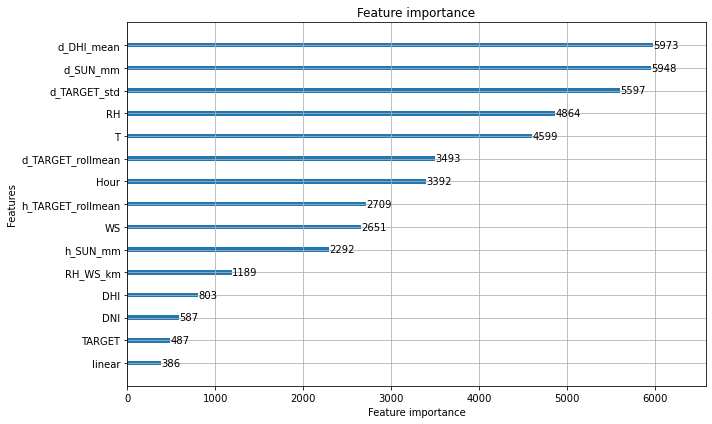

In [104]:
fig, ax = plt.subplots(figsize=(10,6))
plot_importance(model8[1],ax=ax)
plt.tight_layout()


--------------------------------------------------------

# 제출용

## test

In [75]:
test_path="./"

In [76]:
df_test = []

for i in range(81):
    file_path =  test_path+ str(i) + '.csv'

    test=pd.read_csv(file_path)
    
    test['SUN']=test['DNI']+test['DHI']


    test[d_mean_name]=test.groupby('Day')[col_name[3:]].transform(lambda x: x.mean())
    test[d_std_name]=test.groupby('Day')[col_name[3:]].transform(lambda x: x.std())
    test[d_rollmean_name]=test.groupby('Day')[col_name[3:]].transform(lambda x: x.rolling(3).mean())

    test[h_rollstd_name]=test.groupby(['Hour',"Minute"])[col_name[3:]].transform(lambda x: x.rolling(3).std())
    test[h_rollmean_name]=test.groupby(['Hour',"Minute"])[col_name[3:]].transform(lambda x: x.rolling(3).mean())
                                     

    test["d_SUN_mm"]=test.groupby('Day')['SUN'].transform(mm)
    test["h_SUN_mm"]=test.groupby(["Hour","Minute"])['SUN'].transform(mm)


    reg=linear(test,"d_TARGET_mean~Day",k=5,seq=48)


    reg["linear"]=reg.apply(linear2,axis=1)

    test=pd.merge(test,reg.loc[:,["Day","linear"]],on="Day",how="left")
    RH_WS=test[["Day","d_RH_mean","d_WS_mean"]].drop_duplicates(["Day"],keep="first")
    RH_WS2= scaler.transform(RH_WS.iloc[:,1:3])
    RH_WS2=pd.DataFrame(RH_WS2)

    RH_WS_km=kmm.fit_predict(RH_WS2)

    RH_WS["RH_WS_km"]=RH_WS_km
    RH_WS.loc[:,["Day","RH_WS_km"]]

    test=pd.merge(test,RH_WS.loc[:,["Day","RH_WS_km"]],on="Day",how="left")
    test_scaler=scaler2.transform(test[test.columns.difference(["Day","Hour","Minute","linear","RH_WS_km","TARGET"])])
    test[test.columns.difference(["Day","Hour","Minute","linear","RH_WS_km","TARGET"])]=test_scaler

   # test=test.round(3)
    df_test.append(test)
#df_test=df_test.drop(["TARGET","DHI","DNI","WS","RH","T","SUN","Minute","Hour","Day"],axis=1)   
X_test = pd.concat(df_test)
X_test=X_test.fillna(method="bfill")
X_test = X_test[X_test.Day==6]
X_test[["linear","RH_WS_km"]]=X_test[["linear","RH_WS_km"]].astype("category")
X_test["TARGET"]=np.log(X_test["TARGET"]+1)

### 변수선택

In [77]:
test_name=X_test.iloc[:,:9].columns.tolist()

In [78]:
select_list=["d_DHI_mean","linear","RH_WS_km","d_TARGET_rollmean",
             "h_TARGET_rollmean","d_SUN_mm","h_SUN_mm","d_TARGET_std"]


In [79]:
X_test=X_test.loc[:,test_name+select_list]

In [80]:
X_test=X_test.drop(["Day","Minute"],axis=1)

--------------------------------------------------------

--------------------------------------------------------

## Kfold

--------------------------------------------------------

### 7일

#### parameter 수정

In [63]:
n_est=[1500]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])
k_n=2


In [64]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [114]:
sub_kfold_path7="./sub/"

#### 7일 예측모형

In [115]:
from sklearn.model_selection import KFold
folds = KFold(n_splits = k_n, shuffle = True, random_state = 2021)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
            "feature_fraction_bynode":0.8,"bagging_freq":3,
            "num_leaves":par.loc[i,"num_leav"]}                   
                              
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train)) :
        X_train_7, Y_train_7 = train.iloc[trn_idx, :-2], train.iloc[trn_idx, -2] 
        X_valid_7, Y_valid_7 = train.iloc[val_idx, :-2], train.iloc[val_idx, -2]
        
        K_models_7, K_results_7 = train_data(X_train_7, Y_train_7, 
                                         X_valid_7, Y_valid_7,
                                         X_test,param)
        
        joblib.dump(K_models_7, sub_kfold_path7+'model7_%s_fold%s.pkl'%(i,n_fold))
        K_results_7.to_csv(sub_kfold_path7+"result7_%s_fold%s.csv"%(i,n_fold),index=False)


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0682534
[1000]	valid_0's quantile: 0.0675828
[1500]	valid_0's quantile: 0.0660846
Did not meet early stopping. Best iteration is:
[1500]	valid_0's quantile: 0.0660846
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don

### 8일

#### parameter 수정

In [116]:
n_est=[1500]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])
k_n=2


In [117]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 8일 예측모형

In [118]:
sub_kfold_path8="./sub/"

In [119]:
from sklearn.model_selection import KFold
folds = KFold(n_splits = k_n, shuffle = True, random_state = 2021)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
            "feature_fraction_bynode":0.8,"bagging_freq":3,
            "num_leaves":par.loc[i,"num_leav"]}                   
                              
    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train_1)) :
        X_train_8, Y_train_8 = train.iloc[trn_idx, :-2], train.iloc[trn_idx, -1] 
        X_valid_8, Y_valid_8 = train.iloc[val_idx, :-2], train.iloc[val_idx, -1]
        
        K_models_8, K_results_8 = train_data(X_train_8, Y_train_8, 
                                         X_valid_8, Y_valid_8,
                                         X_test,param)
        
        joblib.dump(K_models_8, sub_kfold_path8+'model8_%s_fold%s.pkl'%(i,n_fold))
        K_results_8.to_csv(sub_kfold_path8+"result8_%s_fold%s.csv"%(i,n_fold),index=False)


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0696473
[1000]	valid_0's quantile: 0.0682958
[1500]	valid_0's quantile: 0.0666672
Did not meet early stopping. Best iteration is:
[1492]	valid_0's quantile: 0.0666631
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don

--------------------------------------------------------

## 그냥 모델링

### 7일

#### parameter 수정

In [93]:
n_est=[1500]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])


In [94]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 7일 예측모형

In [95]:
sub_path7="./sub2/"

In [96]:
from sklearn.model_selection import train_test_split
X_train_7, X_valid_7, Y_train_7, Y_valid_7 = train_test_split(train.iloc[:, :-2], 
                                                              train.iloc[:, -2], 
                                                              test_size=0.3, 
                                                              random_state=0)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027#, "feature_fraction":0.7,
           # "feature_fraction_bynode":0.8,"bagging_freq":10,
          #  "num_leaves":par.loc[i,"num_leav"]
          }                   

    
    models_7, results_7 = train_data(X_train_7, Y_train_7, 
                                     X_valid_7, Y_valid_7,
                                     X_test,param)
    
    joblib.dump(models_7,sub_path7+'model7_%s.pkl'%i)
    results_7.to_csv(sub_path7+"result7_%s.csv"%i,index=False)


0.1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.062105
[1000]	valid_0's quantile: 0.0596018
[1500]	valid_0's quantile: 0.0581801
Did not meet early stopping. Best iteration is:
[1500]	valid_0's quantile: 0.0581801
0.2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0856372
[1000]	valid_0's quantile: 0.080696
[1500]	valid_0's quantile: 0.0778486
Did not meet early stopping. Best iteration is:
[1500]	valid_0's quantile: 0.0778486
0.3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0934365
[1000]	valid_0's quantil

--------------------------------------------------------

### 8일

#### parameter 수정

In [87]:
n_est=[1500,3000]
num_leav=[31]
par=[n_est,num_leav]
par=pd.DataFrame(product(*par),columns=["n_est","num_leav"])


In [88]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### 8일 예측모형

In [89]:
sub_path8="./sub2/"

In [90]:
from sklearn.model_selection import train_test_split
X_train_8, X_valid_8, Y_train_8, Y_valid_8 = train_test_split(train.iloc[:, :-2], 
                                                              train.iloc[:, -1], 
                                                              test_size=0.3, 
                                                              random_state=0)

for i in range(len(par)):
    param={"objective":'quantile',
            "n_estimators":par.loc[i,"n_est"],"bagging_fraction":0.7, 
            "learning_rate":0.027, "feature_fraction":0.7,
            "feature_fraction_bynode":0.8,"bagging_freq":10,
            "num_leaves":par.loc[i,"num_leav"]}                   


    models_8, results_8 = train_data(X_train_8, Y_train_8, 
                                     X_valid_8, Y_valid_8,
                                     X_test,param)
    
    joblib.dump(models_8, sub_path8+'model8_%s.pkl'%i)
    results_8.to_csv(sub_path8+"result8_%s.csv"%i,index=False)


0.1
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's quantile: 0.0747896
[1000]	valid_0's quantile: 0.0748028
[1500]	valid_0's quantile: 0.0721177
Did not meet early stopping. Best iteration is:
[1493]	valid_0's quantile: 0.0721085
0.2
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
Training until validation scores

--------------------------------------------------------

--------------------------------------------------------

## 제출파일

In [91]:
submission = pd.read_csv('./sample_submission.csv')

### 예측파일 불러오기

#k랑 model_n을 원한걸로 바꿔서

In [100]:
pred7=subb(sub_path7,k=1,model_n=1,log=True)

In [103]:
pred8=subb(sub_path8,k=1,model_n=2,day=8,log=True)

### submission값을 예측값으로 대체

In [107]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] =pred7.sort_index().values

submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = pred8.sort_index().values

 ### 제출파일저장

In [108]:
submission.to_csv("./sub.csv",index=False)